In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
from datetime import datetime

# Importing models
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preliminar Data Analysis

### My initial procedure will be to first to load the datasets and take a first look at how they look like. 

In [2]:
df_train = pd.read_csv('datasets/train.csv',delimiter=",",low_memory=False)
df_test = pd.read_csv('datasets/test.csv',delimiter=",")
df_store = pd.read_csv('datasets/store.csv',delimiter=",")
df_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


##### We can already see here that the Training dataset is 1017209 rows × 9 columns, so more than one million lines. Clearly this dataset is focused on how much Sales (which is directly related to profit) the stores are making. Therefore, the column "Sales" is the one we will try to predict, but first, we need to take a look at the trends. 

##### However, given that there are more than million lines, possibly the best approach will be to look individually to one store first and then generalize the prediction. Before this, let's look how the data is by trying to answer the simple questions like: are there NaN and nulls? How many zeros do we have in the columns and what do they say?

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
# How many stores are we analyzing? --> 1115
len((df_train['Store']).unique())

1115

In [5]:
# How many unique dates? --> 942
len(df_train['Date'].unique())

942

In [6]:
#Checking if there are NA data or not in the dataset
df_train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [7]:
#Checking if there are Null data or not in the dataset
df_train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [8]:
# Here I am taking a first look at amount of zeros in the columns.
(df_train==0).sum()

Store                 0
DayOfWeek             0
Date                  0
Sales            172871
Customers        172869
Open             172817
Promo            629129
StateHoliday          0
SchoolHoliday    835488
dtype: int64

#### First insights?
##### I get from here is that there could be relation between Sales/Customers and Open columns. It makes sense certainly makes sense given that closed stores can not sell products or welcome customers. However, we need to investigate the correlation if there is one. Another detail here is that StateHoliday (Date) shows no 0 but that's because Dtype is object and not int64 so the 0s there are not counted. 

##### As I mentioned, initially I want to explore the whole dataset and see if I can get some insights (specially trends) from the whole datasets and that's what I going to be doing next.

In [9]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0


##### We can look for seasonalities using <b>statsmodels’ seasonal_decompose function. </b>This function will decompose our time series into trend, seasonality and noise. Here I write a function computing and plotting these seasonalities. Trying to bear in mind that our focus here is the sales (profit) of the company.

In [10]:
def decompose_store_demand(df, share_type='Sales', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=14)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=14)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=1 daily seasonality|Period=30 monthly seasonality,
    axs[2].set_title('SEASONALITY', fontsize=14)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=14)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

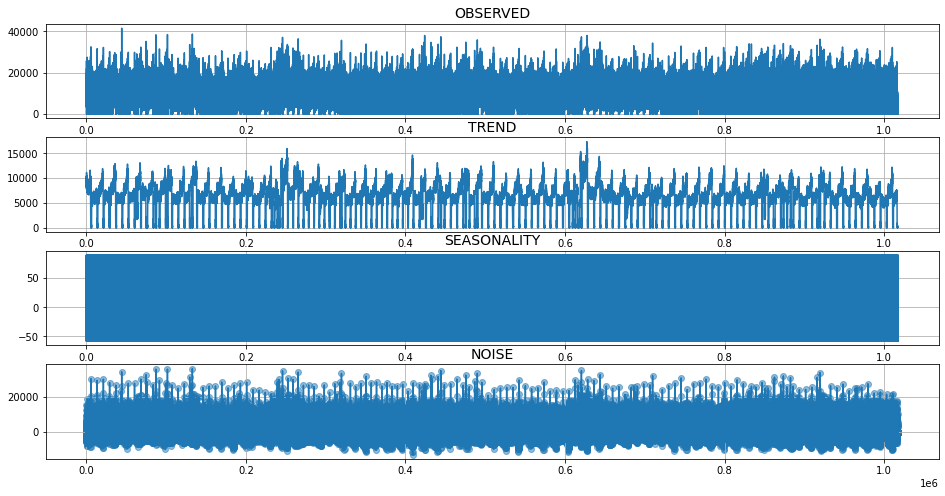

In [11]:
decompose_store_demand(df_train, samples=len(df_train), period=30) 
# Period means the number of days we want to analyse, therefore, period=30 means 30 days (month).

##### Unfortunately, when we look at the whole dataset per month, we are only able to see the trend with the "small" peaks spatially distributed similarly and two "taller" peaks on sales. 

##### Logical question we can tackle in the future: <b>Are these 2 taller peaks related to promotions or Holidays, for instance? </b>

##### I have tried larger periods and the change was not significant, that's because the sample is large (>1x10^6). Therefore, a possible and "safer" approach at this stage is to select a store and investigate it carefully with the goal of understanding the trends and seasonalities as well as the impact of the other parameters (e.g. promotions, competitors, holidays, etc.)

##### Before selecting an specific store I will join both datasets: train_df and df_store by using the primary key: store number.['Store']

In [12]:
# Before, I will just convert the Date dtype to a pandas friendly format.
df_train['Date'] = pd.to_datetime(df_train.Date, format='%Y-%m-%d')
df_test['Date'] = pd.to_datetime(df_test.Date, format='%Y-%m-%d') 


# Joining both the train datasets and the store one by the primary key "Store"
df_joint = df_train.merge(df_store,left_on="Store",right_on="Store",how="left")
df_joint.groupby(["Store"]).size().reset_index()
df_joint = df_joint.sort_values(by='Date') # Sorting the data by Dates 

df_joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 1017208 to 0
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [13]:
df_joint.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1016473,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
1016472,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,NaN,NaN,NaN
1016471,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
1016470,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,NaN,NaN,NaN


# Analyzing a single store first

#### Note: Important to note here, this is an exploratory analysis, so I am just exploring how is the data distributed in a single store and some particularities. Which means that I will have an overview in a single store and then move back to modelling the whole sales in all stores.

#### I believe it does not make sense to <b> MODEL </b> each single store individually for two main reasons: first, it will be hard to interpret and understand if all of the models are working well; second, probably there are stores with less records or missing values and they are going to have bad models in this case.



In [14]:
# First I will select randomly a store to analyse, I simply used: 
# random_store = random.randint(1,1115) and got 150
# I will not keep the code above because the idea is to select a store and analyze it, 
# I do not want to necessarily randomly selecting a store each time as the initial goal is to look at a single one.
random_store = 150 

df_single_store = df_joint[df_joint['Store']==random_store]

In [15]:
# Simplying sorting the dataset by date to better visualize
df_single_store["Date"] = df_single_store["Date"].astype('datetime64[ns]')
df_single_store.sort_values(by='Date', inplace = True)
df_single_store.reset_index(inplace=True)
df_single_store.drop(labels='index', axis=1, inplace=True)

df_single_store

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,150,2,2013-01-01,0,0,0,0,a,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
1,150,3,2013-01-02,6913,762,1,0,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
2,150,4,2013-01-03,6391,743,1,0,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
3,150,5,2013-01-04,7337,767,1,0,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
4,150,6,2013-01-05,6993,736,1,0,0,0,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,150,1,2015-07-27,13768,1119,1,1,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
938,150,2,2015-07-28,10785,904,1,1,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
939,150,3,2015-07-29,10648,893,1,1,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
940,150,4,2015-07-30,11755,1048,1,1,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN


#### Quick impression from this store: 1. no information on continued promotions; 2. This is a storetype 'c', which is a bias in the analysis; 3. Competition is very far and its been there for about three years since the first records of our dataset;

In [16]:
# Checking if there are NA data or not in the dataset
df_single_store.isna().sum()

# I am aware that there are other stores which NaN values are present. 
# At this stage, selecting one that show no NaN will not impact the preliminary analysis.

Store                          0
DayOfWeek                      0
Date                           0
Sales                          0
Customers                      0
Open                           0
Promo                          0
StateHoliday                   0
SchoolHoliday                  0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              942
Promo2SinceYear              942
PromoInterval                942
dtype: int64

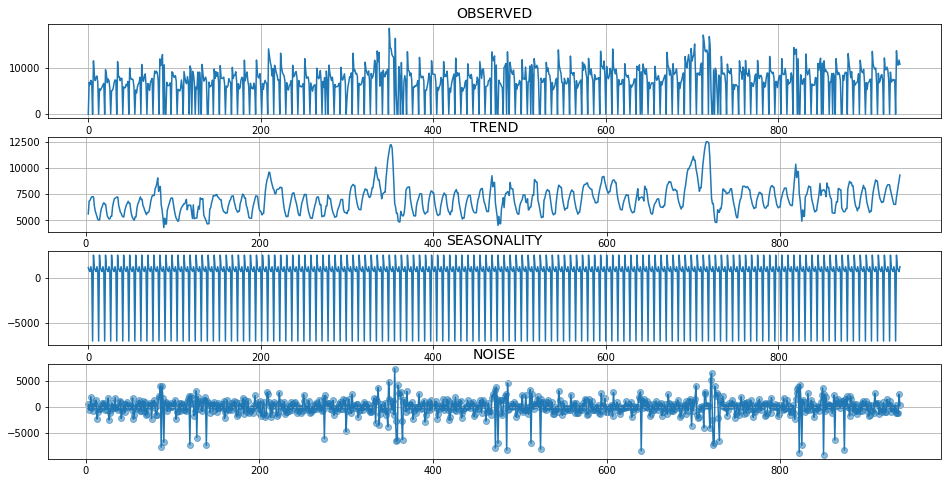

In [17]:
# Let's take a look at the trends and seasonalities now with the function we built above.
# I initially selected a week period (period =7) here.

decompose_store_demand(df_single_store, samples=len(df_single_store), period=7) 

##### There we go! We can extract a lot of insights from the graphs above. If we look closely, we can see a clear weekly seasonal pattern with 2 peeks and a valley between them. Most of the peaks in the noise are related to the peaks on the trend as well, but despite this pattern, there is still a lot of noise that is not explained by our daily seasonality so we will try to model this noise using other variables in the dataset and some feature engineering. 

Text(0, 0.5, 'Sales')

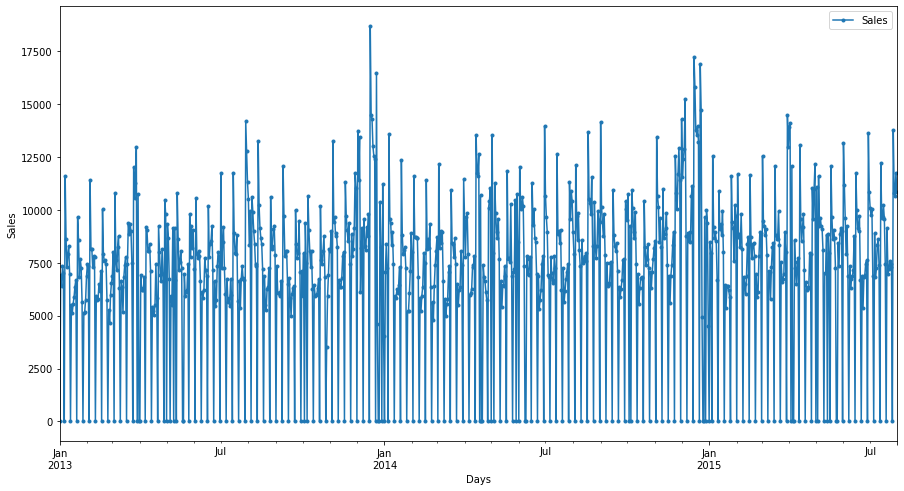

In [18]:
# Plotting here the distribution of sales in time.
df_single_store.plot(x='Date',y='Sales', style='.-', figsize=(15, 8))
plt.xlabel('Days')
plt.ylabel('Sales')

#### First questions we can try to answer now for the store 150 is: 
<b>
    
- How many of these 0 sales correspond to the dates this store was closed? 
- Do the peaks we see correspond to weekend days and/or promotions? 
    
</b>

We do not have information regarding promotions for this store. :)
So our option is to look for the effect of weekends and holidays.
Hypothesis: The two taller peaks possibly coincide with periods close to x-mas, we can investigate it. 

In [19]:
zero_sales_date = df_single_store[df_single_store['Sales']==0]

# Select the columns of interest
columns_of_interest = ['DayOfWeek', 'Date', 'Open', 'StateHoliday', 'SchoolHoliday']
zero_sales_df = zero_sales_date[columns_of_interest]
zero_sales_df

# We already know now that among the 942 dates we have, 158 of them are zeros.

,DayOfWeek,Date,Open,StateHoliday,SchoolHoliday
0,2,2013-01-01,0,a,1
5,7,2013-01-06,0,0,0
12,7,2013-01-13,0,0,0
19,7,2013-01-20,0,0,0
26,7,2013-01-27,0,0,0
...,...,...,...,...,...
908,7,2015-06-28,0,0,0
915,7,2015-07-05,0,0,0
922,7,2015-07-12,0,0,0
929,7,2015-07-19,0,0,0


In [20]:
print(len(zero_sales_df[(zero_sales_df['Open'] ==0)])) # 0 means closed

# Therefore, the days SALES were 0, were exactly days the store was closed. 
# This store is reasonabily sucessfull given it sells things everyday it is open. :D

# Here we could even look if the store was closed due to holidays.
# Weekends correspond to DayOfWeek 6 and 7, but it is open on DayOfWeek=6, so I am considering only 7
print(f'Number of Days Sales are 0 on weekend days:',len(zero_sales_df[(zero_sales_df['DayOfWeek'] == 7)]))
# Therefore, 134 days without Sales out of 158 on DayOfWeek 7 = Sunday. :)

#But How many of them are Holidays?
print(f'Number of Days Sales are 0 on Holidays:',len(zero_sales_df[(zero_sales_df['SchoolHoliday'] == 1) |
                                                                   (zero_sales_df['StateHoliday'] == 'a') |
                                                                  (zero_sales_df['StateHoliday'] == 'b') |
                                                                   (zero_sales_df['StateHoliday'] == 'c')
                                                                  ]))

158
Number of Days Sales are 0 on weekend days: 134
Number of Days Sales are 0 on Holidays: 24


In [21]:
# Here I am cleaning the data by simply removing the dates where the Sales are zero. Since, in our analyse above,
# we identified that the sales are zero simply because the store is closed due to DayOfWeek=7 and/or Holidays.
sales_date = df_single_store[df_single_store['Sales']!=0]

# Select the columns of interest
columns_of_interest = ['DayOfWeek', 'Sales', 'Customers', 'Date', 'Open', 'StateHoliday', 'SchoolHoliday', 'Store']
sales_df = sales_date[columns_of_interest]
sales_date


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,150,3,2013-01-02,6913,762,1,0,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
2,150,4,2013-01-03,6391,743,1,0,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
3,150,5,2013-01-04,7337,767,1,0,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
4,150,6,2013-01-05,6993,736,1,0,0,0,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
6,150,1,2013-01-07,11580,978,1,1,0,0,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,150,1,2015-07-27,13768,1119,1,1,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
938,150,2,2015-07-28,10785,904,1,1,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
939,150,3,2015-07-29,10648,893,1,1,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN
940,150,4,2015-07-30,11755,1048,1,1,0,1,c,c,31830.0,3.0,2010.0,0,NaN,NaN,NaN


Text(0, 0.5, 'Sales')

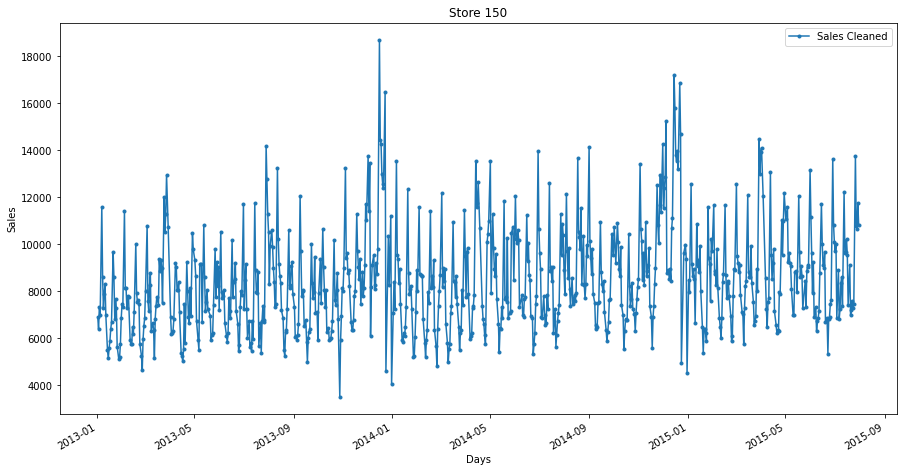

In [22]:
# Plotting here the distribution of sales in time.
sales_df.plot(x='Date',y='Sales',style='.-', 
                figsize=(15, 8), label="Sales Cleaned",title='Store '+str(random_store))
plt.xlabel('Days')
plt.ylabel('Sales')

#### Despite my effort, it is still difficult to determine patterns from this image here. We still only see the two taller peaks which possibly correspond to the x-mas period. Therefore, I will follow the approach of looking to the moving average in given windows.

In [23]:
# moving average
a = ['Store','Date','Sales']
new_df = sales_df[a]
def moving_average(df,janelas=7):
    df = new_df.copy()
    df = df.iloc[::-1] #inverting the dataframe
    for window in janelas:
        #perform the moving average of the "past"
        df['sales_roll_mean_' + str(window)] = df.groupby(["Store"])['Sales']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .mean().reset_index(0,drop=True))
        # Perform the moving sum of the past
        df['sales_roll_sum_' + str(window)] = df.groupby(["Store"])['Sales']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .sum().reset_index(0,drop=True))
    
    return df.iloc[::-1] #inverting back

In [24]:
ss_ma = moving_average(sales_df,[7,15,21,30]) #single store moving average for 7, 15 and 30 days

In [25]:
ss_ma

,Store,Date,Sales,sales_roll_mean_7,sales_roll_sum_7,sales_roll_mean_15,sales_roll_sum_15,sales_roll_mean_21,sales_roll_sum_21,sales_roll_mean_30,sales_roll_sum_30
1,150,2013-01-02,6913,8016.428571,56115.0,7101.533333,106523.0,7246.809524,152183.0,7251.033333,217531.0
2,150,2013-01-03,6391,8287.857143,58015.0,7320.000000,109800.0,7185.476190,150895.0,7280.466667,218414.0
3,150,2013-01-04,7337,8236.428571,57655.0,7403.333333,111050.0,7083.190476,148747.0,7296.266667,218888.0
4,150,2013-01-05,6993,8024.428571,56171.0,7392.600000,110889.0,7023.904762,147502.0,7321.666667,219650.0
6,150,2013-01-07,11580,7104.285714,49730.0,7131.066667,106966.0,6798.714286,142773.0,7133.666667,214010.0
...,...,...,...,...,...,...,...,...,...,...,...
937,150,2015-07-27,13768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,150,2015-07-28,10785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,150,2015-07-29,10648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,150,2015-07-30,11755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


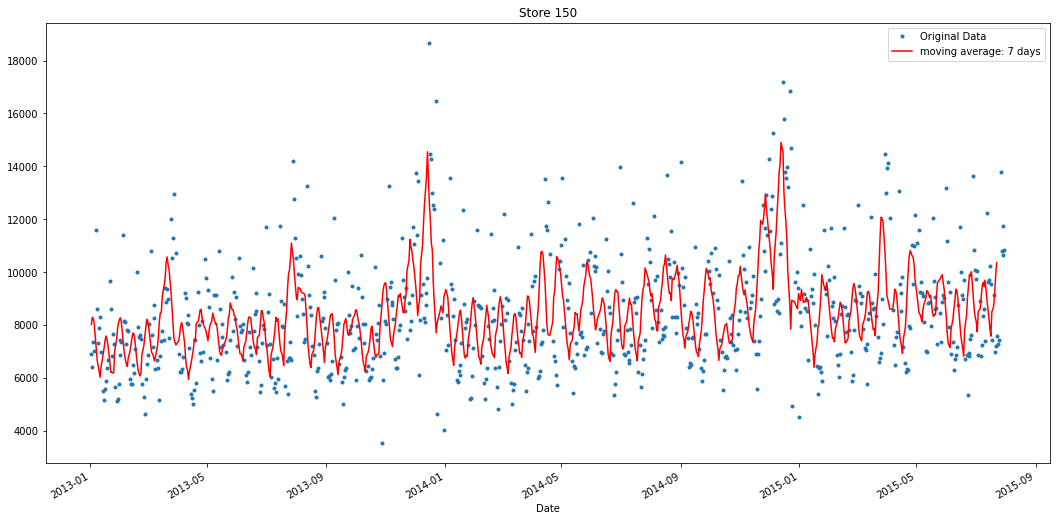

In [26]:
fig, ax = plt.subplots(figsize=(18, 9))

sales_df.plot(ax=ax, x='Date', y='Sales', style='.',
          title='Store 150', label='Original Data')

ss_ma.plot(ax=ax, x='Date', y='sales_roll_mean_7', style='-', color="red", label='moving average: 7 days')
ax.legend()
plt.show()

#### Using the moving average of 7 days we can already see that patterns start to appear. As a consequence, when I perform the model, I will be using either the moving average or the sum average of the Sales per day as a target.

##### Bellow I will be showing the moving averages for given windows.

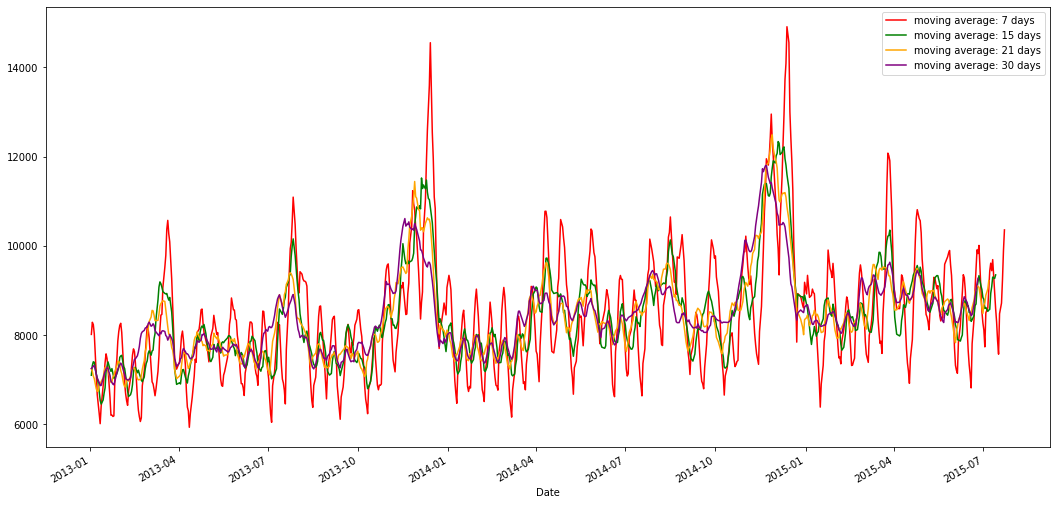

In [27]:
fig, ax = plt.subplots(figsize=(18, 9))

#sales_df.plot(ax=ax, x='Date', y='Sales', style='.',
          #title='Store 150', label='Original Data')

ss_ma.plot(ax=ax, x='Date', y='sales_roll_mean_7', style='-', color="red", label='moving average: 7 days')
ss_ma.plot(ax=ax, x='Date', y='sales_roll_mean_15', style='-', color="green", label='moving average: 15 days')
ss_ma.plot(ax=ax, x='Date', y='sales_roll_mean_21', style='-', color="orange", label='moving average: 21 days')
ss_ma.plot(ax=ax, x='Date', y='sales_roll_mean_30', style='-', color="purple", label='moving average: 30 days')
ax.legend()
plt.show()


#### First thing we see is that as longer is the window we take as smoother it gets the even, to decide which of them I will select a smaller period of time. 

In [28]:
# Smaller period of time
test_period = ss_ma[(ss_ma['Date']>='2013-04-01') & (ss_ma['Date']<='2014-04-01')]
test_period

,Store,Date,Sales,sales_roll_mean_7,sales_roll_sum_7,sales_roll_mean_15,sales_roll_sum_15,sales_roll_mean_21,sales_roll_sum_21,sales_roll_mean_30,sales_roll_sum_30
91,150,2013-04-02,6913,7402.857143,51820.0,6932.066667,103981.0,7083.904762,148762.0,7376.266667,221288.0
92,150,2013-04-03,6200,7665.428571,53658.0,6906.400000,103596.0,7120.190476,149524.0,7474.433333,224233.0
93,150,2013-04-04,6217,7975.714286,55830.0,7108.333333,106625.0,7323.142857,153786.0,7489.666667,224690.0
94,150,2013-04-05,6312,8090.857143,56636.0,7221.800000,108327.0,7488.380952,157256.0,7639.533333,229186.0
95,150,2013-04-06,6800,7889.428571,55226.0,7230.133333,108452.0,7608.095238,159770.0,7700.066667,231002.0
...,...,...,...,...,...,...,...,...,...,...,...
450,150,2014-03-27,6352,9091.714286,63642.0,8391.133333,125867.0,8893.142857,186756.0,8984.000000,269520.0
451,150,2014-03-28,8040,9072.285714,63506.0,8638.733333,129581.0,8825.285714,185331.0,9043.733333,271312.0
452,150,2014-03-29,7394,8871.571429,62101.0,8919.333333,133790.0,8764.571429,184056.0,9095.866667,272876.0
454,150,2014-03-31,11443,8105.285714,56737.0,9000.133333,135002.0,8492.857143,178350.0,9002.833333,270085.0


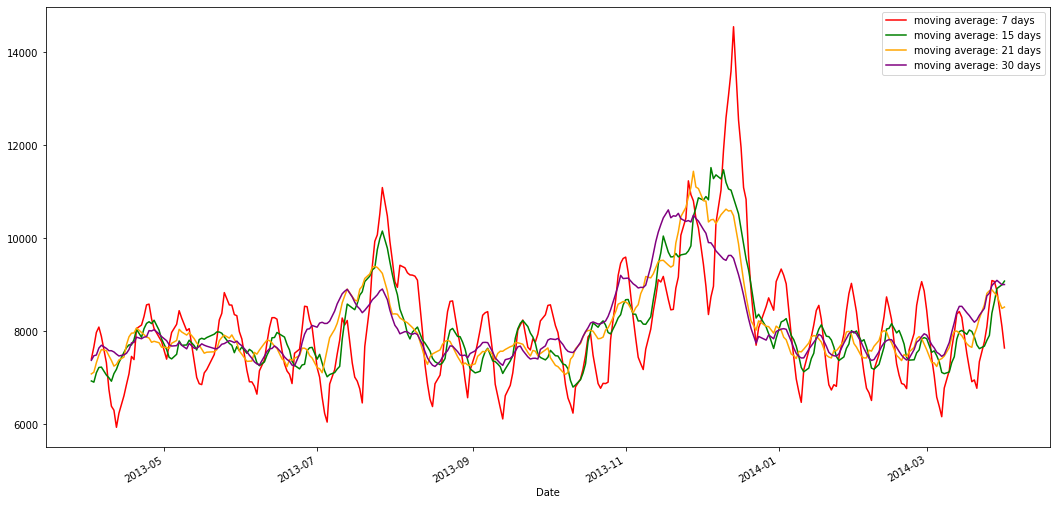

In [29]:
fig, ax = plt.subplots(figsize=(18, 9))

test_period.plot(ax=ax, x='Date', y='sales_roll_mean_7', style='-', color="red", label='moving average: 7 days')
test_period.plot(ax=ax, x='Date', y='sales_roll_mean_15', style='-', color="green", label='moving average: 15 days')
test_period.plot(ax=ax, x='Date', y='sales_roll_mean_21', style='-', color="orange", label='moving average: 21 days')
test_period.plot(ax=ax, x='Date', y='sales_roll_mean_30', style='-', color="purple", label='moving average: 30 days')
ax.legend()
plt.show()


##### We can see that 7 days period is sensitive to single events and 30 is possible too much.

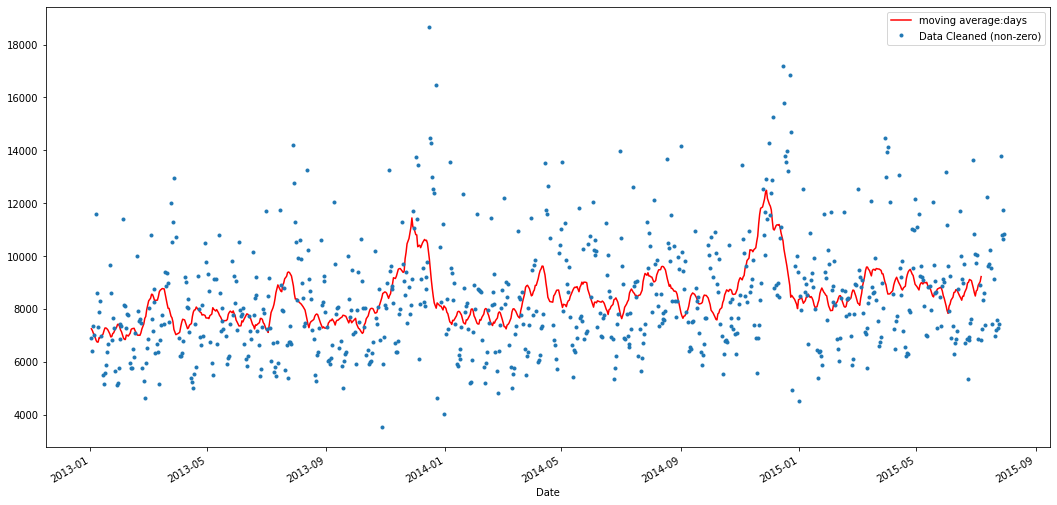

In [30]:
fig, ax = plt.subplots(figsize=(18, 9))

ss_ma.plot(ax=ax, x='Date', y='sales_roll_mean_21', style='-', color="red", label='moving average:days')
ss_ma.plot(ax=ax, x='Date', y='Sales', style='.', label='Data Cleaned (non-zero)')

ax.legend()
plt.show()

In [31]:
df_test.sort_values(by='Date')
print('The earliest date we will predict is: ',min(df_test['Date']))
print('The latest date we will predict is: ',max(df_test['Date']))
print('Amount of data between: ',len(df_test['Date'].unique()))

The earliest date we will predict is:  2015-08-01 00:00:00
The latest date we will predict is:  2015-09-17 00:00:00
Amount of data between:  48


In [32]:
ss_ma_15 = moving_average(sales_df,[7,15]) #single store moving average of 15 days
ss_ma_15.tail(25)

,Store,Date,Sales,sales_roll_mean_7,sales_roll_sum_7,sales_roll_mean_15,sales_roll_sum_15
913,150,2015-07-03,10030,7737.000000,54159.0,8598.466667,128977.0
914,150,2015-07-04,6873,8500.571429,59504.0,8619.800000,129297.0
916,150,2015-07-06,8887,8606.857143,60248.0,8532.333333,127985.0
917,150,2015-07-07,6837,9013.000000,63091.0,8561.933333,128429.0
918,150,2015-07-08,7233,9439.285714,66075.0,8575.533333,128633.0
919,150,2015-07-09,8335,9612.000000,67284.0,8937.733333,134066.0
920,150,2015-07-10,8604,9443.285714,66103.0,9083.133333,136247.0
921,150,2015-07-11,7390,9691.571429,67841.0,9300.333333,139505.0
923,150,2015-07-13,12218,8942.857143,62600.0,9269.466667,139042.0
924,150,2015-07-14,9631,8594.571429,60162.0,9349.133333,140237.0


#### Given we are trying to predict only 48 days in a period of a month a half-ish, possibly the most realiable option is to take either 7 or 15 moving average.

## Feature engineering

### Temporal Feature

In [33]:
def temporal_features(df=df_train):
    """
    This function basically separates the days, weeks and months of the year
    """
    df = df.copy()
    df["DayOfWeek"] = df['DayOfWeek'].fillna(df.Date.dt.dayofweek)
    df["DayOfMonth"]  = df.Date.dt.day
    df["DayOfYear"]   = df.Date.dt.dayofyear
    df["Month"]       = df.Date.dt.month
    df["WeekOfYear"]  = df.Date.dt.isocalendar().week.astype("int64")
    
    return df

In [34]:
sales_date_t=temporal_features(sales_date)
sales_date_t.reset_index()
a=moving_average(sales_date_t,[15])
a
df_sales_date = sales_date_t.merge(a,left_on=["Date","Sales","Store"],right_on=["Date","Sales","Store"],how="inner")
df_sales_date

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfMonth,DayOfYear,Month,WeekOfYear,sales_roll_mean_15,sales_roll_sum_15
0,150,3,2013-01-02,6913,762,1,0,0,1,c,...,0,NaN,NaN,NaN,2,2,1,1,7101.533333,106523.0
1,150,4,2013-01-03,6391,743,1,0,0,1,c,...,0,NaN,NaN,NaN,3,3,1,1,7320.000000,109800.0
2,150,5,2013-01-04,7337,767,1,0,0,1,c,...,0,NaN,NaN,NaN,4,4,1,1,7403.333333,111050.0
3,150,6,2013-01-05,6993,736,1,0,0,0,c,...,0,NaN,NaN,NaN,5,5,1,1,7392.600000,110889.0
4,150,1,2013-01-07,11580,978,1,1,0,0,c,...,0,NaN,NaN,NaN,7,7,1,2,7131.066667,106966.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,150,1,2015-07-27,13768,1119,1,1,0,1,c,...,0,NaN,NaN,NaN,27,208,7,31,NaN,NaN
780,150,2,2015-07-28,10785,904,1,1,0,1,c,...,0,NaN,NaN,NaN,28,209,7,31,NaN,NaN
781,150,3,2015-07-29,10648,893,1,1,0,1,c,...,0,NaN,NaN,NaN,29,210,7,31,NaN,NaN
782,150,4,2015-07-30,11755,1048,1,1,0,1,c,...,0,NaN,NaN,NaN,30,211,7,31,NaN,NaN


In [35]:
def features_moving_sales(df, janelas):
    df = df.copy()
    df = df.iloc[::-1] 
    
    for window in janelas:
        #average of the "past"
        df['target_moving_sum_' + str(window)] = df.groupby(["Store"])['Sales']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .sum().reset_index(0,drop=True))
    return df.iloc[::-1] #invert it back

In [36]:
sales_date = features_moving_sales(sales_date, [7,15,21])

sales_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 1 to 941
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      784 non-null    int64         
 1   DayOfWeek                  784 non-null    int64         
 2   Date                       784 non-null    datetime64[ns]
 3   Sales                      784 non-null    int64         
 4   Customers                  784 non-null    int64         
 5   Open                       784 non-null    int64         
 6   Promo                      784 non-null    int64         
 7   StateHoliday               784 non-null    object        
 8   SchoolHoliday              784 non-null    int64         
 9   StoreType                  784 non-null    object        
 10  Assortment                 784 non-null    object        
 11  CompetitionDistance        784 non-null    float64       
 12  Competit

## Introducting Lag features

#### Since we are doing a forecasting analysis, I will introduce Lag features which are values in past times that are considered useful because we assume that what happened in the past can influence or retain some kind of intrinsic information about the future. Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

#### Remembering that capturing the trend and seasonality is our main goal and then use it to predict the future date

In [37]:
def lag_features(df, lags):
    for lag in lags:
        df['lag_sales_' + str(lag)] = df.groupby(["Store"])['target_moving_sum_21']\
                                        .transform(lambda x: x.shift(lag))
    return df

In [38]:
lags = np.arange(7, 95, 7)
sales_date = lag_features(sales_date,lags)
sales_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 1 to 941
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      784 non-null    int64         
 1   DayOfWeek                  784 non-null    int64         
 2   Date                       784 non-null    datetime64[ns]
 3   Sales                      784 non-null    int64         
 4   Customers                  784 non-null    int64         
 5   Open                       784 non-null    int64         
 6   Promo                      784 non-null    int64         
 7   StateHoliday               784 non-null    object        
 8   SchoolHoliday              784 non-null    int64         
 9   StoreType                  784 non-null    object        
 10  Assortment                 784 non-null    object        
 11  CompetitionDistance        784 non-null    float64       
 12  Competit

In [39]:
sales_date.head(25)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,lag_sales_28,lag_sales_35,lag_sales_42,lag_sales_49,lag_sales_56,lag_sales_63,lag_sales_70,lag_sales_77,lag_sales_84,lag_sales_91
1,150,3,2013-01-02,6913,762,1,0,0,1,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150,4,2013-01-03,6391,743,1,0,0,1,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,150,5,2013-01-04,7337,767,1,0,0,1,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,150,6,2013-01-05,6993,736,1,0,0,0,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,150,1,2013-01-07,11580,978,1,1,0,0,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,150,2,2013-01-08,8619,801,1,1,0,0,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,150,3,2013-01-09,7297,751,1,1,0,0,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,150,4,2013-01-10,7898,776,1,1,0,0,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,150,5,2013-01-11,8291,853,1,1,0,0,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,150,6,2013-01-12,6977,765,1,0,0,0,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
def features_mean_mov(df, janelas):
    for window in janelas:
        df['Sales_moving_mean_' + str(window)] = df.groupby(["Store"])['Sales']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .mean())
    return df

In [41]:
janelas = [7, 15, 35, 65, 95, 120]
sales_date= features_mean_mov(sales_date, janelas)
sales_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 1 to 941
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      784 non-null    int64         
 1   DayOfWeek                  784 non-null    int64         
 2   Date                       784 non-null    datetime64[ns]
 3   Sales                      784 non-null    int64         
 4   Customers                  784 non-null    int64         
 5   Open                       784 non-null    int64         
 6   Promo                      784 non-null    int64         
 7   StateHoliday               784 non-null    object        
 8   SchoolHoliday              784 non-null    int64         
 9   StoreType                  784 non-null    object        
 10  Assortment                 784 non-null    object        
 11  CompetitionDistance        784 non-null    float64       
 12  Competit

In [42]:
sales_date[['Date','target_moving_sum_21']].head(8)

,Date,target_moving_sum_21
1,2013-01-02,152183.0
2,2013-01-03,150895.0
3,2013-01-04,148747.0
4,2013-01-05,147502.0
6,2013-01-07,142773.0
7,2013-01-08,141594.0
8,2013-01-09,141647.0
9,2013-01-10,145163.0


# Single store: Train, Cross-validation and test splits

In [43]:
len(sales_date['Date'].unique())
train_single = sales_date[sales_date['Date'].between("2013-01-01","2014-10-21")]
cross_valid  = sales_date[sales_date['Date'].between("2014-10-22","2015-04-28")]
test_single = sales_date[sales_date['Date'].between("2015-04-29","2015-07-23")]

In [44]:
#rain_single.info()
train_single  =  temporal_features(train_single)
cross_valid   =  temporal_features(cross_valid)
test_single   =  temporal_features(test_single)

In [45]:
train_single.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,549.0,150.000000,0.000000,150.000000,150.000000,150.000000,150.000000,150.000000
DayOfWeek,549.0,3.508197,1.714692,1.000000,2.000000,3.000000,5.000000,6.000000
Sales,549.0,8131.080146,2027.446062,3519.000000,6699.000000,7811.000000,9148.000000,18677.000000
Customers,549.0,804.020036,139.975941,444.000000,710.000000,782.000000,869.000000,1626.000000
Open,549.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Promo,549.0,0.440801,0.496936,0.000000,0.000000,0.000000,1.000000,1.000000
SchoolHoliday,549.0,0.202186,0.401996,0.000000,0.000000,0.000000,0.000000,1.000000
CompetitionDistance,549.0,31830.000000,0.000000,31830.000000,31830.000000,31830.000000,31830.000000,31830.000000
CompetitionOpenSinceMonth,549.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
CompetitionOpenSinceYear,549.0,2010.000000,0.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000


<AxesSubplot:ylabel='Frequency'>

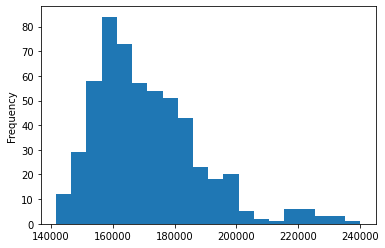

In [46]:
train_single['target_moving_sum_21'].plot(kind='hist',bins=20)

In [47]:
print("Max number of Sales per day:", np.int(train_single["target_moving_sum_21"].max()),"\n",\
      "Min number of Sales per day:", np.int(train_single["target_moving_sum_21"].min()))

Max number of Sales per day: 240265 
 Min number of Sales per day: 141594


#### I could use a categorical and target encoding here to decrease the RAM memory occupied with these features I created. I am still not sure if I am going to work on it, but I want to mention the possibility here.

#### Answer: I am going to need to encode either way: there are some features that the model will not work because they are not int, float, etc. So we need to encod them. I will be trying categorical encoding.

## Categorical and target Encoding 

#### Target encoding, also known as mean encoding, is a technique used in data preparation for machine learning. It involves replacing categorical variables with the mean of the target variable for each category.
#### The main idea here is to encode the categories by replacing them with a measure of the effect they will have on the target Sales per day per store. Let's replace the category with the average value of the target for that category and, to avoid overfitting, let's do an additive smoothing method.

In [48]:
#function that performs the addtive smoothing

def calc_average_smooth(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)


In [49]:
train_encod = train_single.copy()
cv_encod = cross_valid.copy()
test_encod =  test_single.copy()

In [50]:
features     = ['DayOfWeek','DayOfMonth','DayOfYear','Month', #'Store',
                'WeekOfYear','Assortment','StoreType','PromoInterval','StateHoliday']

new_features = ['NDayOfWeek','NDayOfMonth','NDayOfYear','NMonth', #'NStore',
                'NWeekOfYear','NAssortment','NStoreType','NPromoInterval','NStateHoliday']

In [51]:
m = 100 # initial guess
for i in range(len(features)):

    train_encod[new_features[i] ]=calc_average_smooth(train_encod, by=features[i], on='target_moving_sum_21', m=m)


In [52]:
#corresp_store    = train_encod.groupby(['Store','NStore'])\
#                             .size().reset_index()[['Store', 'NStore']]

corresp_week  = train_encod.groupby(['DayOfWeek','NDayOfWeek'])\
                             .size().reset_index()[['DayOfWeek', 'NDayOfWeek']]

corresp_day_month  = train_encod.groupby(['DayOfMonth','NDayOfMonth'])\
                             .size().reset_index()[['DayOfMonth','NDayOfMonth']]
 
corresp_year     = train_encod.groupby(['DayOfYear', 'NDayOfYear'])\
                             .size().reset_index()[['DayOfYear','NDayOfYear']]

corresp_month     = train_encod.groupby(['Month', 'NMonth'])\
                             .size().reset_index()[['Month','NMonth']]

corresp_week_year = train_encod.groupby(['WeekOfYear','NWeekOfYear'])\
                             .size().reset_index()[['WeekOfYear','NWeekOfYear']]

corresp_assort= train_encod.groupby(['Assortment','NAssortment'])\
                             .size().reset_index()[['Assortment','NAssortment']]

corresp_store_type= train_encod.groupby(['StoreType','NStoreType'])\
                             .size().reset_index()[['StoreType','NStoreType']]

corresp_promo_int = train_encod.groupby(['PromoInterval','NPromoInterval'])\
                             .size().reset_index()[['PromoInterval','NPromoInterval']]

corresp_state_holi =train_encod.groupby(['StateHoliday','NStateHoliday'])\
                             .size().reset_index()[['StateHoliday','NStateHoliday']]


In [53]:
corresp = [corresp_week,corresp_day_month, corresp_year,corresp_month, #corresp_store,
           corresp_week_year,corresp_assort,corresp_store_type,corresp_promo_int,corresp_state_holi]

In [54]:
for i in range(len(features)):
    test_encod = test_encod.merge(corresp[i], on=features[i], how="left")
    cv_encod   = cv_encod.merge(corresp[i], on=features[i], how="left")


In [55]:
# removing categorical features, leaving only their encoded values
for i in range(len(features)):
    test_encod.drop(features[i], axis=1, inplace=True)
    cv_encod.drop(features[i], axis=1, inplace=True)
    train_encod.drop(features[i], axis=1, inplace=True)

In [56]:
train_encod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549 entries, 1 to 658
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      549 non-null    int64         
 1   Date                       549 non-null    datetime64[ns]
 2   Sales                      549 non-null    int64         
 3   Customers                  549 non-null    int64         
 4   Open                       549 non-null    int64         
 5   Promo                      549 non-null    int64         
 6   SchoolHoliday              549 non-null    int64         
 7   CompetitionDistance        549 non-null    float64       
 8   CompetitionOpenSinceMonth  549 non-null    float64       
 9   CompetitionOpenSinceYear   549 non-null    float64       
 10  Promo2                     549 non-null    int64         
 11  Promo2SinceWeek            0 non-null      float64       
 12  Promo2Si

In [57]:
test_encod['Date'].tail(8)

63   2015-07-15
64   2015-07-16
65   2015-07-17
66   2015-07-18
67   2015-07-20
68   2015-07-21
69   2015-07-22
70   2015-07-23
Name: Date, dtype: datetime64[ns]

In [58]:
train_encod

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Sales_moving_mean_120,NDayOfWeek,NDayOfMonth,NDayOfYear,NMonth,NWeekOfYear,NAssortment,NStoreType,NPromoInterval,NStateHoliday
1,150,2013-01-02,6913,762,1,0,1,31830.0,3.0,2010.0,...,NaN,170846.124815,170729.830586,170923.223919,165792.387103,170167.613208,171135.118397,171135.118397,NaN,171135.118397
2,150,2013-01-03,6391,743,1,0,1,31830.0,3.0,2010.0,...,NaN,171383.882750,170331.981377,170879.733723,165792.387103,170167.613208,171135.118397,171135.118397,NaN,171135.118397
3,150,2013-01-04,7337,767,1,0,1,31830.0,3.0,2010.0,...,NaN,171274.093402,170237.065331,170847.165095,165792.387103,170167.613208,171135.118397,171135.118397,NaN,171135.118397
4,150,2013-01-05,6993,736,1,0,0,31830.0,3.0,2010.0,...,NaN,171402.375462,170564.074283,170901.127126,165792.387103,170167.613208,171135.118397,171135.118397,NaN,171135.118397
6,150,2013-01-07,11580,978,1,1,0,31830.0,3.0,2010.0,...,NaN,170914.520209,170813.536468,170718.900389,165792.387103,168962.944997,171135.118397,171135.118397,NaN,171135.118397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,150,2014-10-16,6772,709,1,0,1,31830.0,3.0,2010.0,...,8574.800000,171383.882750,171731.049073,171180.439605,169822.523355,171199.819997,171135.118397,171135.118397,NaN,171135.118397
654,150,2014-10-17,6822,749,1,0,1,31830.0,3.0,2010.0,...,8572.325000,171274.093402,170882.532540,171205.067056,169822.523355,171199.819997,171135.118397,171135.118397,NaN,171135.118397
655,150,2014-10-18,6762,713,1,0,0,31830.0,3.0,2010.0,...,8569.350000,171402.375462,171048.830586,171226.037644,169822.523355,171199.819997,171135.118397,171135.118397,NaN,171135.118397
657,150,2014-10-20,10422,940,1,1,1,31830.0,3.0,2010.0,...,8538.441667,170914.520209,171177.015724,171240.830096,169822.523355,171143.470738,171135.118397,171135.118397,NaN,171135.118397


## Single store: Building the model: XGBReg

### I chose for this work the model XGBReg because forecasting and prediction tasks specifically, XGBoost can be a good choice as it can handle both continuous and categorical data, and can be used for both regression and classification problems. It also supports time series analysis, which is important for many forecasting applications. Overall, XGBoost is a powerful and flexible tool that can be used for a wide range of machine learning tasks, including forecasting and prediction.

### There are other possibilities like RandomForest,TensorFlow and even the microsoft version of XGBReg that some say are better optmized. Of course, one could spend as much time as possible exploring different models and checking which one performs better under the conditions we have, but I believe, at this stage, we are not interested on this.

In [59]:
# Training the model
X_train_s = train_encod.drop(['Sales','target_moving_sum_21','Date'],axis=1)
Y_train_s = train_encod['target_moving_sum_21']

X_test_s = test_encod.drop(['Sales','target_moving_sum_21','Date'],axis=1)
Y_test_s = test_encod['target_moving_sum_21']

X_cross_valid_s = cv_encod.drop(['Sales','target_moving_sum_21','Date'],axis=1)
Y_cross_valid_s = cv_encod['target_moving_sum_21']

In [60]:
print(X_train_s.shape , Y_train_s.shape, X_cross_valid_s.shape, Y_cross_valid_s.shape, X_test_s.shape , Y_test_s.shape)

(549, 41) (549,) (157, 41) (157,) (71, 41) (71,)


In [61]:
%%time
regrXGB_s = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.008,
                          )

regrXGB_s.fit(X_train_s, Y_train_s,
        eval_set=[(X_train_s._get_numeric_data(), Y_train_s._get_numeric_data()), 
                  (X_cross_valid_s._get_numeric_data(), Y_cross_valid_s._get_numeric_data())],
        verbose=100)

[15:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:170628.85938	validation_1-rmse:194266.76562
[100]	validation_0-rmse:77197.20312	validation_1-rmse:95325.82812
[200]	validation_0-rmse:35261.76953	validation_1-rmse:50582.16406
[300]	validation_0-rmse:16517.34961	validation_1-rmse:30822.05469
[400]	validation_0-rmse:8312.14062	validation_1-rmse:22293.31836
[500]	validation_0-rmse:4924.81787	validation_1-rmse:18683.58789
[600]	validation_0-rmse:3603.37158	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.008, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Single store: Analizying the model

### SMAPE, MAE, RMSE, and R2 are metrics commonly used to evaluate the performance of regression models. Here's a brief summary of what each of these metrics tells us: 

- SMAPE (Symmetric Mean Absolute Percentage Error) measures the percentage difference between actual and predicted values. It is a symmetric version of Mean Absolute Percentage Error (MAPE) that is not affected by the direction of the error. SMAPE is typically used when the scale of the variables being predicted is important.

- MAE (Mean Absolute Error) measures the average absolute difference between the predicted and actual values. It is less sensitive to outliers than other error metrics and is often used when the model needs to be optimized for accuracy rather than precision.

- RMSE (Root Mean Squared Error) measures the standard deviation of the residuals (the difference between the predicted and actual values). It is a popular metric because it penalizes large errors more than small errors and is more interpretable than the variance of the residuals.

- R2 (Coefficient of Determination) measures the proportion of variance in the dependent variable that is explained by the independent variable(s). It ranges from 0 to 1, with 1 indicating a perfect fit and 0 indicating that the model does not explain any of the variation in the dependent variable.


##### In general, a good model will have low values of SMAPE, MAE, and RMSE, and a high value of R2. However, the ideal values of these metrics depend on the specific problem being solved and the underlying data. It is also important to use multiple metrics to evaluate model performance and to compare the results with other models and benchmarks.

In [62]:
def smape(predict, data):
    return 100/len(data) * np.sum(np.abs(predict - data) / (np.abs(data) + np.abs(predict)))

In [63]:
def print_metrics_s(X, Y,model=regrXGB_s):
    print( "SMAPE:", smape(model.predict(X), Y) )
    print("\tMean absolute error (MAE):", mean_absolute_error(Y, model.predict(X)))
    print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(Y, model.predict(X))))
    print("\tR2 score:", r2_score(Y, model.predict(X)))
    
    return

In [64]:
print_metrics_s(X_train_s,Y_train_s)

SMAPE: 0.5563190452066467
	Mean absolute error (MAE): 1904.279485428051
	Root Mean squared error (RMSE): 2354.940980036014
	R2 score: 0.9811787581980828


In [65]:
print_metrics_s(X_cross_valid_s,Y_cross_valid_s)

SMAPE: 3.0191813001814882
	Mean absolute error (MAE): 11869.709295382165
	Root Mean squared error (RMSE): 15652.13446602058
	R2 score: 0.5506419154820561


In [66]:
#print_metrics_s(X_test_s, Y_test_s)

#### R2 score is pretty bad for the cross validation and test datasets. Two possible explanations: the datasets (test and CV) are too small, given we considered only one store; Overfitting, which is pretty common with XGBoost, another possibility would be try another model like traditional Decision tree or try to analyse curse of dimensionality and sparse data;

In [67]:
Y_train_s.describe().reset_index()

,index,target_moving_sum_21
0,count,549.000000
1,mean,171135.118397
2,std,17181.132341
3,min,141594.000000
4,25%,159008.000000
5,50%,167586.000000
6,75%,180605.000000
7,max,240265.000000


In [68]:
# Predicting the values
predict_train = regrXGB_s.predict(X_train_s)
predict_cross_valid = regrXGB_s.predict(X_cross_valid_s)
predict_test = regrXGB_s.predict(X_test_s)

train_single['Predicted-target']  =  predict_train
cross_valid['Predicted-target']  =  predict_cross_valid
test_single['Predicted-target']  =  predict_test

In [69]:
def plot_comparison(df):
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(df['Date'], df['target_moving_sum_21'], color="black", label='Original'
              )
    ax.plot(df['Date'], df['Predicted-target'], color="red", label='Predicted Target'
              )
    ax.legend()
    plt.show()

    return

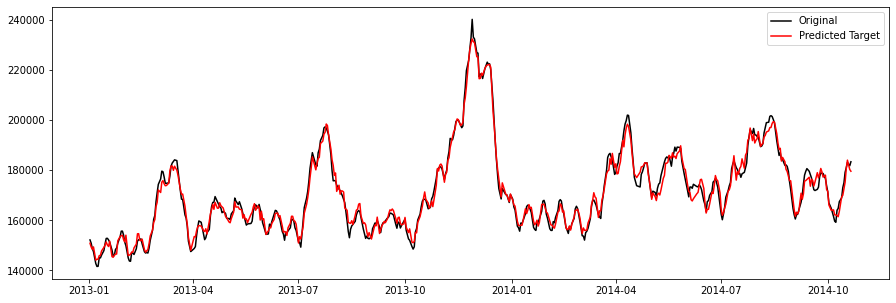

In [70]:
plot_comparison(train_single) # For the training dataset

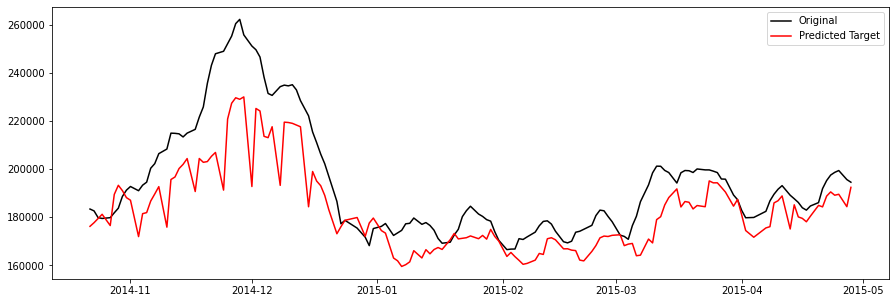

In [71]:
plot_comparison(cross_valid) # For the cross-validation dataset

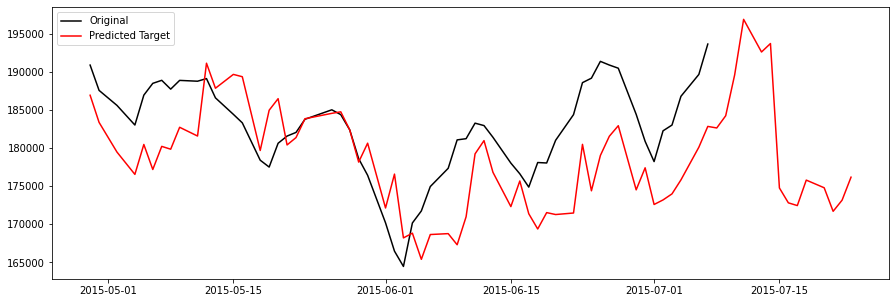

In [72]:
plot_comparison(test_single) # For the test dataset

### It seems to me that the model is indeed overfitting here...
### To get some extra insight, I will analyze the importance of each feature in this particular model.

In [73]:
feature_importance_s= pd.DataFrame(data=regrXGB_s.feature_importances_,
                 index  = regrXGB_s.get_booster().feature_names,
                 columns= ['importance'])
feature_importance_s.sort_values('importance', ascending=False).head(10)

,importance
target_moving_sum_15,0.468090
NDayOfYear,0.141021
NWeekOfYear,0.064692
Sales_moving_mean_120,0.034587
Promo,0.025445
Sales_moving_mean_95,0.021029
target_moving_sum_7,0.019081
lag_sales_84,0.018999
NMonth,0.018747
lag_sales_35,0.016798


<Figure size 720x360 with 0 Axes>

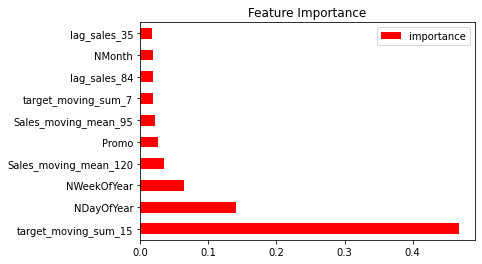

In [74]:
plt.figure(figsize=(10, 5))
fig1 = feature_importance_s.sort_values('importance', ascending=False).head(10)
fig1.plot(kind='barh', title='Feature Importance',color='red')
plt.legend(loc='upper right')
plt.show()

### Here, a decision has to be taken, we could analyze this overfitting: check the model, see the influence of the features on the model, etc. However, I believe we have gone far enough by just analyzing only a SINGLE store. <b>It is time to go back to the whole dataset and analyze it as whole.</b>

# All Stores

In [75]:
## Here we go with the Dataset that is already joint between train.csv and store.csv
test_a= df_joint.copy()

In [76]:
test_df = test_a.loc[(test_a['Sales'] == 0) & (test_a['Open'] == 1), :]
print(len(test_df))
print(len(test_df['Store'].unique()))
print(len(test_df['Date'].unique()))

# Remember I checked that in the store 150 all the days the store was open, there were Sales?
# I am doing the same now, and among all the 1e6 data we have, only in 54 occasions a given 
# store was opened and did not have any Sales.
# At the moment, I will keep all the information and then later I can check if it affects or not.

54
41
49


#### A priori, these are outliers in our analysis, we can check it later if it improves our model or not.  

## Missing values: Dealing with them
### After performing some initial analysis in this data, I noticed that some stores (eg. 670, ...) have some periods that no data is present, which basically means that not even the column 'Date' is included in the dataframe. This can be a problem when we run the model, since some store will have very few data available for a given period. There are several ways of dealing with this, I will try two approachs: 1. I will compute the mean of the Sales, then include the missing Dates with this mean. 2. I will do the same, but I will also include a column that states where date were included (just a way to tag what was included in my code). In some cases, the model can take advantage of this, in others, it doesn't make much of a difference.

#### There are naturally better solutions than just taking the mean of Sales, like look for days of week in previous years and etc. But let's feed with the mean and see what happens. 

In [77]:
def check_dates(df):
    store1_dates = df[df['Store'] == 1]['Date'].nunique()
    store_dates = df.groupby('Store')['Date'].nunique()
    stores_with_diff_dates = pd.DataFrame()
    stores_with_diff_dates['Store'] = store_dates[store_dates != store1_dates].index.tolist()
    return stores_with_diff_dates

In [78]:
check_dates(test_a)

,Store
0,13
1,20
2,22
3,32
4,36
...,...
176,1094
177,1102
178,1104
179,1107


This is an important result for our analysis: Among 1115 Stores, 181 of them have dates missing in the dataFrame. Therefore, we need to identify which dates are missing and fill them.

In [79]:
def find_different_dates(df):
    # Get the dates for the first store
    store_1_dates = set(df[df['Store'] == 1]['Date'])
    
    # Initialize an empty DataFrame to hold the results
    result_df = pd.DataFrame(columns=['Store', 'Date'])
    
    # Loop over the stores
    for store in df['Store'].unique():
        # Get the dates for the current store
        store_dates = set(df[df['Store'] == store]['Date'])
        
        # If the number of dates is different from the first store, add the different dates to the result DataFrame
        if len(store_dates) != len(store_1_dates):
            different_dates = store_dates.symmetric_difference(store_1_dates)
            for date in different_dates:
                result_df = result_df.append({'Store': store, 'Date': date}, ignore_index=True)
    
    return result_df

In [80]:
%%time
test_ab = find_different_dates(test_a)
test_ab['Store']=test_ab['Store'].astype("int64")
print('Total amount of Dates being added to the stores:',len(test_ab)) 

Total amount of Dates being added to the stores: 33121
CPU times: user 1min 49s, sys: 663 ms, total: 1min 50s
Wall time: 1min 50s


In [81]:
# Concatanating both datasets, this is create a dataframe with NaN values where I inserted the new dates.
conca_df = pd.concat([test_a,test_ab],axis=0)
conca_df = conca_df.sort_values(['Store','Date'])

In [82]:
# Here I am creating an artifact (a new column) where I keep the information to keep track where the new dates where included.
conca_df['Sales'].isnull()
conca_df['Date included'] = np.where(conca_df['Sales'].notnull() & conca_df['Date'].isin(test_a['Date']), 0, 1) #0 for False and 1 for True

In [83]:
sum(conca_df['Date included']==1) # Double checking, everything seems fine so far.

33121

In [84]:
conca_df['Sales'] = conca_df.groupby('Store')['Sales'].transform(lambda x: x.fillna(float(np.round(x.mean(),1))))

In [85]:
sum(conca_df['Sales'].isnull())

0

In [86]:
# Feature Engineering
conca_df=temporal_features(conca_df)
conca_df.reset_index()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date included,DayOfMonth,DayOfYear,Month,WeekOfYear
0,1016095,1,2.0,2013-01-01,0.0,0.0,0.0,0.0,a,1.0,...,2008.0,0.0,NaN,NaN,NaN,0,1,1,1,1
1,1014980,1,3.0,2013-01-02,5530.0,668.0,1.0,0.0,0,1.0,...,2008.0,0.0,NaN,NaN,NaN,0,2,2,1,1
2,1013865,1,4.0,2013-01-03,4327.0,578.0,1.0,0.0,0,1.0,...,2008.0,0.0,NaN,NaN,NaN,0,3,3,1,1
3,1012750,1,5.0,2013-01-04,4486.0,619.0,1.0,0.0,0,1.0,...,2008.0,0.0,NaN,NaN,NaN,0,4,4,1,1
4,1011635,1,6.0,2013-01-05,4997.0,635.0,1.0,0.0,0,1.0,...,2008.0,0.0,NaN,NaN,NaN,0,5,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050325,5574,1115,1.0,2015-07-27,10712.0,608.0,1.0,1.0,0,1.0,...,NaN,1.0,22.0,2012.0,"Mar,Jun,Sept,Dec",0,27,208,7,31
1050326,4459,1115,2.0,2015-07-28,8093.0,500.0,1.0,1.0,0,1.0,...,NaN,1.0,22.0,2012.0,"Mar,Jun,Sept,Dec",0,28,209,7,31
1050327,3344,1115,3.0,2015-07-29,7661.0,473.0,1.0,1.0,0,1.0,...,NaN,1.0,22.0,2012.0,"Mar,Jun,Sept,Dec",0,29,210,7,31
1050328,2229,1115,4.0,2015-07-30,8405.0,502.0,1.0,1.0,0,1.0,...,NaN,1.0,22.0,2012.0,"Mar,Jun,Sept,Dec",0,30,211,7,31


In [87]:
# Now we have to compute the target moving sum for 21 days
total_train = features_moving_sales(conca_df, [21])

In [88]:
total_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050330 entries, 1016095 to 1114
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1050330 non-null  int64         
 1   DayOfWeek                  1050330 non-null  float64       
 2   Date                       1050330 non-null  datetime64[ns]
 3   Sales                      1050330 non-null  float64       
 4   Customers                  1017209 non-null  float64       
 5   Open                       1017209 non-null  float64       
 6   Promo                      1017209 non-null  float64       
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  float64       
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567

In [89]:
# Now, I am computing the lag features
lags = np.arange(7, 95, 7)
total_train = lag_features(total_train,lags)

In [90]:
total_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050330 entries, 1016095 to 1114
Data columns (total 37 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1050330 non-null  int64         
 1   DayOfWeek                  1050330 non-null  float64       
 2   Date                       1050330 non-null  datetime64[ns]
 3   Sales                      1050330 non-null  float64       
 4   Customers                  1017209 non-null  float64       
 5   Open                       1017209 non-null  float64       
 6   Promo                      1017209 non-null  float64       
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  float64       
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567

In [91]:
# Here I will have to perform the target encoding in this data.
# I chose to do train = 70% of the dataset, cross_valid = 20% and test_ = 10%.
train_t = total_train[total_train['Date'].between("2013-01-01","2014-10-21")] 
cross_valid_t = total_train[total_train['Date'].between("2014-10-22","2015-04-28")]
test_t = total_train[total_train['Date'].between("2015-04-29","2015-07-24")] # Selecting until target_moving_sum is not NaN
test_t_2 = total_train[total_train['Date'].between("2015-04-29","2015-07-31")] # Selecting everything

In [92]:
train_encod = train_t.copy()
cv_encod = cross_valid_t.copy()
test_encod =  test_t.copy()
test_encod_2 =  test_t_2.copy()

In [93]:
store123 = test_t_2[test_t_2['Store']==123]
store123[['target_moving_sum_21','Date']].tail(10)

,target_moving_sum_21,Date
10157,NaN,2015-07-22
9042,NaN,2015-07-23
7927,NaN,2015-07-24
6812,NaN,2015-07-25
5697,NaN,2015-07-26
4582,NaN,2015-07-27
3467,NaN,2015-07-28
2352,NaN,2015-07-29
1237,NaN,2015-07-30
122,NaN,2015-07-31


In [94]:
features     = ['DayOfWeek','DayOfMonth','DayOfYear','Month',
                'WeekOfYear','Assortment','StoreType','PromoInterval','StateHoliday']

new_features = [ 'NDayOfWeek','NDayOfMonth','NDayOfYear','NMonth',
                'NWeekOfYear','NAssortment','NStoreType','NPromoInterval','NStateHoliday']

In [95]:
m = 100 # initial guess
for i in range(len(features)):

    train_encod[new_features[i] ]=calc_average_smooth(train_encod, by=features[i], on='target_moving_sum_21', m=m) 
    #Here I am choosing to analyze the target_moving_sum_21


In [96]:
#corresp_store    = train_encod.groupby(['Store','NStore'])\
#                             .size().reset_index()[['Store', 'NStore']]

corresp_week  = train_encod.groupby(['DayOfWeek','NDayOfWeek'])\
                             .size().reset_index()[['DayOfWeek', 'NDayOfWeek']]

corresp_day_month  = train_encod.groupby(['DayOfMonth','NDayOfMonth'])\
                             .size().reset_index()[['DayOfMonth','NDayOfMonth']]
 
corresp_year     = train_encod.groupby(['DayOfYear', 'NDayOfYear'])\
                             .size().reset_index()[['DayOfYear','NDayOfYear']]

corresp_month     = train_encod.groupby(['Month', 'NMonth'])\
                             .size().reset_index()[['Month','NMonth']]

corresp_week_year = train_encod.groupby(['WeekOfYear','NWeekOfYear'])\
                             .size().reset_index()[['WeekOfYear','NWeekOfYear']]

corresp_assort= train_encod.groupby(['Assortment','NAssortment'])\
                             .size().reset_index()[['Assortment','NAssortment']]

corresp_store_type= train_encod.groupby(['StoreType','NStoreType'])\
                             .size().reset_index()[['StoreType','NStoreType']]

corresp_promo_int = train_encod.groupby(['PromoInterval','NPromoInterval'])\
                             .size().reset_index()[['PromoInterval','NPromoInterval']]

corresp_state_holi =train_encod.groupby(['StateHoliday','NStateHoliday'])\
                             .size().reset_index()[['StateHoliday','NStateHoliday']]


In [97]:
corresp = [corresp_week,corresp_day_month, corresp_year,corresp_month,
           corresp_week_year,corresp_assort,corresp_store_type,corresp_promo_int,corresp_state_holi]

In [98]:
for i in range(len(features)):
    test_encod = test_encod.merge(corresp[i], on=features[i], how="left")
    test_encod_2 = test_encod_2.merge(corresp[i], on=features[i], how="left")
    cv_encod   = cv_encod.merge(corresp[i], on=features[i], how="left")


In [99]:
# Removing the categorical features, leaving only the encoded values
for i in range(len(features)):
    test_encod.drop(features[i], axis=1, inplace=True)
    test_encod_2.drop(features[i], axis=1, inplace=True)
    cv_encod.drop(features[i], axis=1, inplace=True)
    train_encod.drop(features[i], axis=1, inplace=True)

In [100]:
train_encod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 734785 entries, 1016095 to 303699
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      734785 non-null  int64         
 1   Date                       734785 non-null  datetime64[ns]
 2   Sales                      734785 non-null  float64       
 3   Customers                  714444 non-null  float64       
 4   Open                       714444 non-null  float64       
 5   Promo                      714444 non-null  float64       
 6   SchoolHoliday              714444 non-null  float64       
 7   CompetitionDistance        712580 non-null  float64       
 8   CompetitionOpenSinceMonth  487373 non-null  float64       
 9   CompetitionOpenSinceYear   487373 non-null  float64       
 10  Promo2                     714444 non-null  float64       
 11  Promo2SinceWeek            358661 non-null  fl

# All Stores: Modelling the whole Dataset

In [101]:
X_train_t = train_encod.drop(['Sales','target_moving_sum_21','Date'],axis=1)
Y_train_t = train_encod['target_moving_sum_21']

X_test_t = test_encod.drop(['Sales','target_moving_sum_21','Date'],axis=1)
Y_test_t = test_encod['target_moving_sum_21']

X_cross_valid_t = cv_encod.drop(['Sales','target_moving_sum_21','Date'],axis=1)
Y_cross_valid_t = cv_encod['target_moving_sum_21']

X_test_t_2 = test_encod_2.drop(['Sales','target_moving_sum_21','Date'],axis=1)
Y_test_t_2 = test_encod_2['target_moving_sum_21']

In [102]:
X_train_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 734785 entries, 1016095 to 303699
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      734785 non-null  int64  
 1   Customers                  714444 non-null  float64
 2   Open                       714444 non-null  float64
 3   Promo                      714444 non-null  float64
 4   SchoolHoliday              714444 non-null  float64
 5   CompetitionDistance        712580 non-null  float64
 6   CompetitionOpenSinceMonth  487373 non-null  float64
 7   CompetitionOpenSinceYear   487373 non-null  float64
 8   Promo2                     714444 non-null  float64
 9   Promo2SinceWeek            358661 non-null  float64
 10  Promo2SinceYear            358661 non-null  float64
 11  Date included              734785 non-null  int64  
 12  lag_sales_7                726980 non-null  float64
 13  lag_sales_14           

In [103]:
print(X_train_t.shape , Y_train_t.shape, X_cross_valid_t.shape, Y_cross_valid_t.shape, X_test_t.shape , Y_test_t.shape,X_test_t_2.shape , Y_test_t_2.shape)

(734785, 34) (734785,) (210735, 34) (210735,) (97005, 34) (97005,) (104810, 34) (104810,)


In [104]:
%%time

regrXGB_t = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.008,
                          )

regrXGB_t.fit(X_train_t, Y_train_t,
        eval_set=[(X_train_t, Y_train_t),
                  (X_cross_valid_t, Y_cross_valid_t)],
        verbose=100)

[15:02:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:126287.47656	validation_1-rmse:132958.00000
[100]	validation_0-rmse:57668.23438	validation_1-rmse:60877.05078
[200]	validation_0-rmse:27574.04102	validation_1-rmse:29271.14258
[300]	validation_0-rmse:15123.11523	validation_1-rmse:15904.85840
[400]	validation_0-rmse:10560.53516	validation_1-rmse:10912.82617
[500]	validation_0-rmse:8979.89941	validation_1-rmse:9154.67188
[600]	validation_0-rmse:8349.82129	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.008, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

### Let's print the metrics to check the quality of our model

In [105]:
print_metrics_s(X_train_t,Y_train_t,model=regrXGB_t)

SMAPE: 2.070859671447028
	Mean absolute error (MAE): 4602.478322621583
	Root Mean squared error (RMSE): 7458.392928262669
	R2 score: 0.9718125701612456


In [106]:
print_metrics_s(X_cross_valid_t,Y_cross_valid_t,model=regrXGB_t)

SMAPE: 2.3518027820785323
	Mean absolute error (MAE): 5800.807898945952
	Root Mean squared error (RMSE): 7944.94838176618
	R2 score: 0.970143373922353


In [107]:
#print_metrics_s(X_test_t, Y_test_t,model=regrXGB_t)

#### In here we can already see that SMAPE and R2 score are reasonably good for this model. Let's look at the comparisons between original and prediction.

In [108]:
predict_train = regrXGB_t.predict(X_train_t).astype('float64')
predict_cross_valid = regrXGB_t.predict(X_cross_valid_t).astype('float64')
predict_test = regrXGB_t.predict(X_test_t).astype('float64')
predict_test_2 = regrXGB_t.predict(X_test_t_2).astype('float64')


train_encod['Predicted-target']  =  predict_train
cv_encod['Predicted-target']  =  predict_cross_valid
test_encod['Predicted-target']  =  predict_test
test_encod_2['Predicted-target']  =  predict_test_2

### As a matter of fact, we have to analyze the stores individually to see how the model is performing individually. I selected, a priori, the same store we were analyzing previously: Store 150. Let's see.

In [109]:
cv_150 = cv_encod[cv_encod['Store'] == 150]
train_150 = train_encod[train_encod['Store'] == 150]
test_150 = test_encod[test_encod['Store'] == 150]

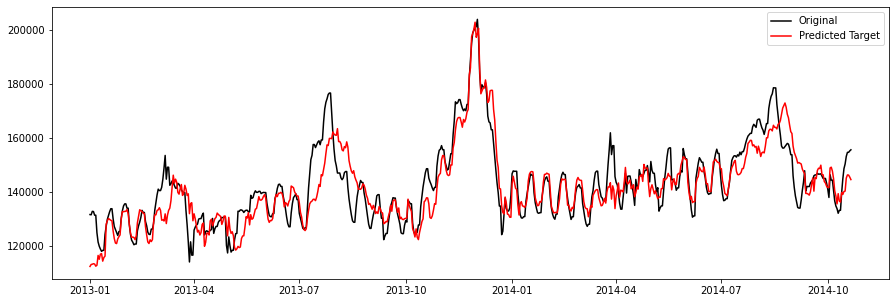

In [110]:
plot_comparison(train_150)

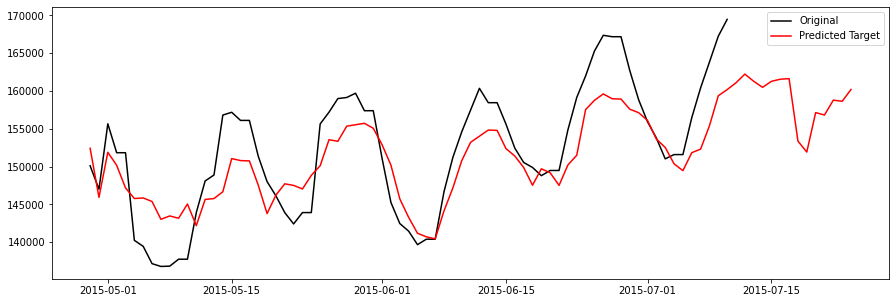

In [111]:
plot_comparison(test_150)

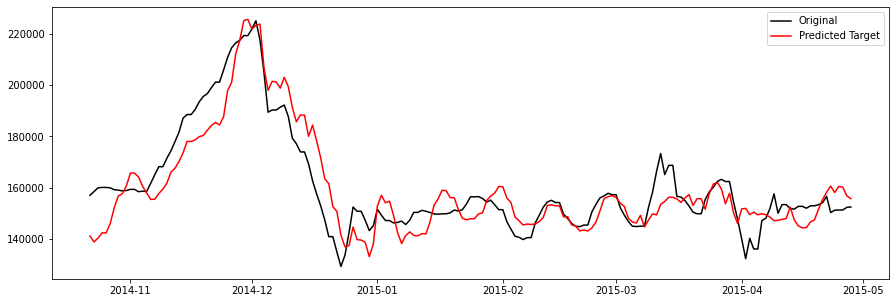

In [112]:
plot_comparison(cv_150)

### There is always room for improvement but, to me, the results of this model are reasonable and I could use them to predict the values for the future. Let's take a look at a second "random" store just to check.

In [113]:
cv_670 = cv_encod[cv_encod['Store'] == 670]
train_670 = train_encod[train_encod['Store'] == 670]
test_670 = test_encod[test_encod['Store'] == 670]

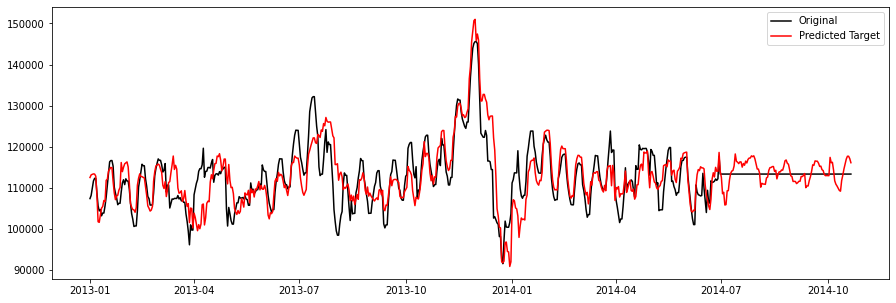

In [114]:
plot_comparison(train_670)

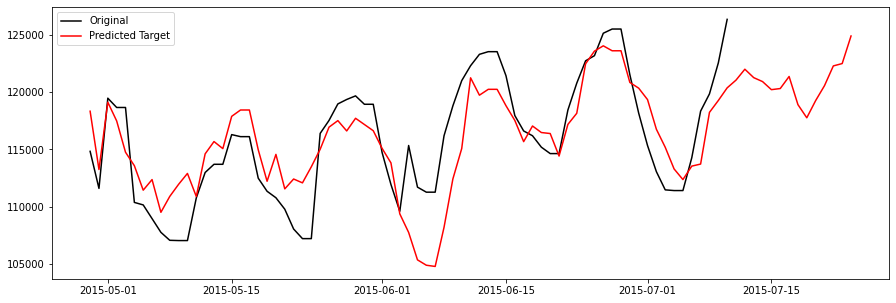

In [115]:
plot_comparison(test_670)

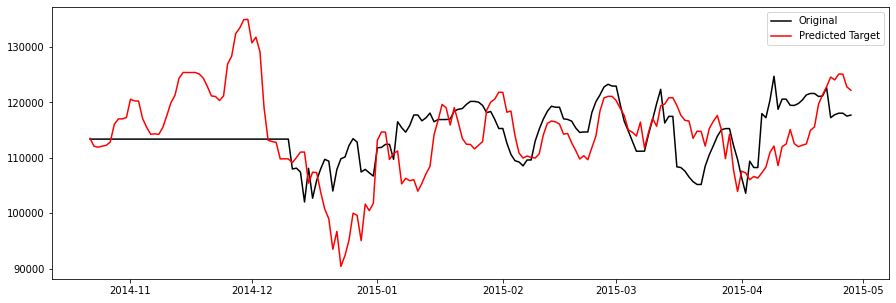

In [116]:
plot_comparison(cv_670)

## Feature Importance in this model

In [117]:
feature_importance= pd.DataFrame(data = regrXGB_t.feature_importances_,
                 index  = regrXGB_t.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
lag_sales_14,0.431139
lag_sales_7,0.350622
lag_sales_56,0.044665
lag_sales_42,0.027884
lag_sales_28,0.026480
lag_sales_63,0.024515
lag_sales_91,0.016596
NWeekOfYear,0.011921
NDayOfYear,0.011783
Customers,0.009862


<Figure size 720x360 with 0 Axes>

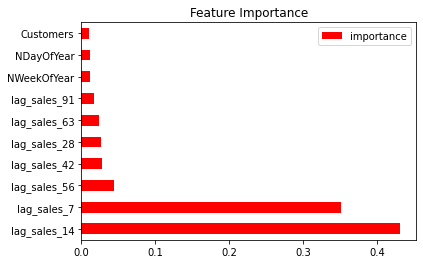

In [118]:
# Plotting the features with higher importance in the model
plt.figure(figsize=(10, 5))
fig2 = feature_importance.sort_values('importance', ascending=False).head(10)
fig2.plot(kind='barh', title='Feature Importance',color='red')
plt.legend(loc='upper right')
plt.show()

### The lag features we included are very important in this model, which means that to model the data the past results are indeed affecting the prediction. In my opinion, this is very good and consistent with this kind of analysis.

# All Stores: Final Model

In [119]:
# Putting together all datasets, train, cross-validation and test
Dataset_all = pd.concat([train_encod, cv_encod, test_encod_2]).reset_index(0,drop=True)

### So I have a crucial and possibly non-ideal assumption to make here. I didn't have time to find a more sophisticated solution but I have to sort it out the fact that the last 7 days of my dataset: no target_moving_sum_21 are computed. Therefore, given my model has performed well so far and the predicted-target is very comparable to the target_moving_sum_21, I will modify the last 21 target_moving_sum_21 ( NaN) with the predicted-target our model computed. I repeat, this is certainly not ideal and may bring biases but I can't find a better solution now and I am close to this assignment's deadline. :)

In [120]:
# Doing what I just described above
Dataset_all['target_moving_sum_21'] = Dataset_all['target_moving_sum_21'].fillna(Dataset_all['Predicted-target'])

In [121]:
Dataset_all = features_mean_mov(Dataset_all, janelas)

In [122]:
# Training the model
X_all = Dataset_all.drop(['Sales','target_moving_sum_21','Date','Predicted-target'],axis=1)
Y_all = Dataset_all['target_moving_sum_21']

In [123]:
%%time
# Training the model
regrXGB_all = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1200,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.008,
                          )

CPU times: user 138 µs, sys: 478 µs, total: 616 µs
Wall time: 689 µs


In [124]:
regrXGB_all.fit(X_all, Y_all,eval_set=[(X_all, Y_all)],verbose=100)

[17:09:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:128081.44531
[100]	validation_0-rmse:58448.28516
[200]	validation_0-rmse:27879.78125
[300]	validation_0-rmse:15167.98047
[400]	validation_0-rmse:10451.14453
[500]	validation_0-rmse:8817.77539
[600]	validation_0-rmse:8140.02881
[700]	validation_0-rmse:7778.01562
[800]	validation_0-rmse:7526.54443
[900]	validation_0-rmse:7325.29541
[1000]	validation_0-rmse:7163.03809
[1100]	validation_0-rmse:7021.38037
[1199]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.008, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1200, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [125]:
Dataset_all['target_moving_sum_21'].describe().reset_index()

,index,target_moving_sum_21
0,count,1.050330e+06
1,mean,1.211266e+05
2,std,4.467224e+04
3,min,0.000000e+00
4,25%,9.195600e+04
5,50%,1.138480e+05
6,75%,1.401440e+05
7,max,5.219800e+05


In [126]:
print_metrics_s(X_all,Y_all,model=regrXGB_all)

SMAPE: 1.923119033966358
	Mean absolute error (MAE): 4382.656951116331
	Root Mean squared error (RMSE): 6904.64964553246
	R2 score: 0.976110429868329


In [127]:
feature_importance= pd.DataFrame(data = regrXGB_all.feature_importances_,
                 index  = regrXGB_all.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
lag_sales_14,0.475360
lag_sales_7,0.267062
lag_sales_56,0.063293
lag_sales_42,0.039215
lag_sales_91,0.029315
lag_sales_63,0.022917
lag_sales_28,0.017626
NWeekOfYear,0.010875
lag_sales_49,0.008826
NDayOfYear,0.008510


<Figure size 720x360 with 0 Axes>

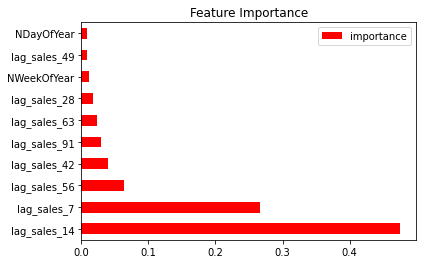

In [128]:
# Plotting the features with higher importance in the model
plt.figure(figsize=(10, 5))
fig2 = feature_importance.sort_values('importance', ascending=False).head(10)
fig2.plot(kind='barh', title='Feature Importance',color='red')
plt.legend(loc='upper right')
plt.show()

## R2 and SMAPE are good, in my opinion. I certaintly could play a bit more with the parameters of the model like: n_estimator or max_depth to improve it, but I will keep it like this for this analysis.

# All Stores: Prediction of the future!!

In [129]:
Dataset_all.shape

(1050330, 44)

In [150]:
data_all = Dataset_all[['Store', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','target_moving_sum_21',
       'Promo2SinceYear', 'NDayOfWeek','NDayOfMonth', 'NDayOfYear', 'NMonth', 'NWeekOfYear', 'NAssortment',
       'NStoreType', 'NPromoInterval', 'NStateHoliday', 'Predicted-target','Date included']]

In [151]:
df_future = df_test.copy() # df_test is the initial dataset the file test.csv 
                           # provided for this assignment was loaded in.

In [152]:
df_future

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [153]:
df_future = df_future.drop('Id', axis=1) # just dropping the id column

In [154]:
df_future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          41088 non-null  int64         
 1   DayOfWeek      41088 non-null  int64         
 2   Date           41088 non-null  datetime64[ns]
 3   Open           41077 non-null  float64       
 4   Promo          41088 non-null  int64         
 5   StateHoliday   41088 non-null  object        
 6   SchoolHoliday  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.2+ MB


In [155]:
df_future = temporal_features(df_future)

In [156]:
df_future = df_future.merge(corresp_week, on='DayOfWeek', how='left')
df_future = df_future.merge(corresp_day_month, on='DayOfMonth', how='left')
df_future = df_future.merge(corresp_month, on='Month', how='left')
df_future = df_future.merge(corresp_year, on='DayOfYear', how='left')
df_future = df_future.merge(corresp_week_year, on='WeekOfYear', how='left')
df_future = df_future.merge(corresp_state_holi, on='StateHoliday', how='left')

df_future.sort_values(by='Date', inplace = True)

In [157]:
df_future = df_future[['Store', 'Date', 'Open', 'Promo','SchoolHoliday','NDayOfWeek', 
                       'NDayOfMonth', 'NMonth', 'NDayOfYear', 'NWeekOfYear','NStateHoliday']]
df_future.columns

Index(['Store', 'Date', 'Open', 'Promo', 'SchoolHoliday', 'NDayOfWeek',
       'NDayOfMonth', 'NMonth', 'NDayOfYear', 'NWeekOfYear', 'NStateHoliday'],
      dtype='object')

In [158]:
# Concatenating both datasets
df_all = pd.concat([data_all,df_future],ignore_index=True)#.reset_index(0,drop=True) #(df1, df2, on=['Store', 'Date'], how='outer')

In [159]:
df_all.sort_values(['Store','Date'], inplace=True) # I prefer to see the past dates on the top. :D

In [160]:
df_all

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,NDayOfMonth,NDayOfYear,NMonth,NWeekOfYear,NAssortment,NStoreType,NPromoInterval,NStateHoliday,Predicted-target,Date included
0,1,2013-01-01,0.0,0.0,0.0,0.0,1.0,1270.0,9.0,2008.0,...,121263.264221,117239.389514,116532.780508,117167.235188,114072.118567,118209.710219,NaN,119565.405244,112540.671875,0.0
1,1,2013-01-02,5530.0,668.0,1.0,0.0,1.0,1270.0,9.0,2008.0,...,120327.778432,117858.164622,116532.780508,117167.235188,114072.118567,118209.710219,NaN,119479.542094,113122.242188,0.0
2,1,2013-01-03,4327.0,578.0,1.0,0.0,1.0,1270.0,9.0,2008.0,...,119600.783507,118682.087368,116532.780508,117167.235188,114072.118567,118209.710219,NaN,119479.542094,113315.617188,0.0
3,1,2013-01-04,4486.0,619.0,1.0,0.0,1.0,1270.0,9.0,2008.0,...,117875.900924,119012.821274,116532.780508,117167.235188,114072.118567,118209.710219,NaN,119479.542094,113417.359375,0.0
4,1,2013-01-05,4997.0,635.0,1.0,0.0,1.0,1270.0,9.0,2008.0,...,116578.301655,118958.068055,116532.780508,117167.235188,114072.118567,118209.710219,NaN,119479.542094,113376.867188,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087780,1115,2015-09-13,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,119540.140031,112489.157883,116007.362770,113893.110609,NaN,NaN,NaN,119479.542094,NaN,NaN
1088421,1115,2015-09-14,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,...,120589.447514,112587.848441,116007.362770,118091.104944,NaN,NaN,NaN,119479.542094,NaN,NaN
1089412,1115,2015-09-15,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,...,121157.906357,112715.536424,116007.362770,118091.104944,NaN,NaN,NaN,119479.542094,NaN,NaN
1090269,1115,2015-09-16,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,...,121181.762520,114892.851446,116007.362770,118091.104944,NaN,NaN,NaN,119479.542094,NaN,NaN


In [161]:
df_andre = df_all.copy() # the moment I lost creativity with the variable names

In [162]:
df_andre.shape

(1091418, 25)

In [163]:
df_andre = lag_features(df_andre,lags) # Computing lag_features

In [164]:
df_andre=features_mean_mov(df_andre, janelas)

In [165]:
df_andre.shape

(1091418, 44)

In [167]:
df_andre.columns

Index(['Store', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'target_moving_sum_21', 'Promo2SinceYear', 'NDayOfWeek', 'NDayOfMonth',
       'NDayOfYear', 'NMonth', 'NWeekOfYear', 'NAssortment', 'NStoreType',
       'NPromoInterval', 'NStateHoliday', 'Predicted-target', 'Date included',
       'lag_sales_7', 'lag_sales_14', 'lag_sales_21', 'lag_sales_28',
       'lag_sales_35', 'lag_sales_42', 'lag_sales_49', 'lag_sales_56',
       'lag_sales_63', 'lag_sales_70', 'lag_sales_77', 'lag_sales_84',
       'lag_sales_91', 'Sales_moving_mean_7', 'Sales_moving_mean_15',
       'Sales_moving_mean_35', 'Sales_moving_mean_65', 'Sales_moving_mean_95',
       'Sales_moving_mean_120'],
      dtype='object')

In [168]:
X = df_andre.drop(['Sales','target_moving_sum_21','Date','Predicted-target'],axis=1)

In [169]:
pred = regrXGB_all.predict(X)
df_andre['Pred'] = pred.astype('float64')

In [170]:
df_andre['Pred']

0          111844.062500
1          111525.781250
2          111735.351562
3          110781.492188
4          110066.015625
               ...      
1087780    114624.250000
1088421    114438.242188
1089412    114230.570312
1090269    112199.023438
1091124    112621.046875
Name: Pred, Length: 1091418, dtype: float64

In [172]:
# Here I am basically estimating the Sales for the dates this assignment requires,
# I am simply dividing the Predicted values for the target_moving_sum_7 by 7.

#df_andre=features_diff_mov(df_andre,[21])
df_andre['Sales'] = df_andre['Sales'].fillna(df_andre['Pred']/21)
#df_andre['Sales'] = df_andre['Sales'].fillna(abs(df_andre['Sales_moving_diff_21']))

# Note here: Simply dividing by 7 can cause some underprediction for the sales 

In [173]:
# Preparing the final table to save the results into a csv file.
df_andre[['Date','Store','Sales','target_moving_sum_21','Pred']]

,Date,Store,Sales,target_moving_sum_21,Pred
0,2013-01-01,1,0.000000,89384.0,111844.062500
1,2013-01-02,1,5530.000000,89432.0,111525.781250
2,2013-01-03,1,4327.000000,90300.0,111735.351562
3,2013-01-04,1,4486.000000,91400.0,110781.492188
4,2013-01-05,1,4997.000000,92001.0,110066.015625
...,...,...,...,...,...
1087780,2015-09-13,1115,5458.297619,NaN,114624.250000
1088421,2015-09-14,1115,5449.440104,NaN,114438.242188
1089412,2015-09-15,1115,5439.550967,NaN,114230.570312
1090269,2015-09-16,1115,5342.810640,NaN,112199.023438


In [174]:
# I am just checking how the future was predicted
testing = df_andre[(df_andre['Store']==810)&(df_andre['Date']<='2015-07-31')&(df_andre['Open']==1)]
testing2 = df_andre[(df_andre['Store']==810)&(df_andre['Date']>'2015-07-31')&(df_andre['Open']==1)]

In [175]:
testing2

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,lag_sales_77,lag_sales_84,lag_sales_91,Sales_moving_mean_7,Sales_moving_mean_15,Sales_moving_mean_35,Sales_moving_mean_65,Sales_moving_mean_95,Sales_moving_mean_120,Pred
1051121,810,2015-08-01,5452.876488,NaN,1.0,0.0,0.0,NaN,NaN,NaN,...,102857.0,93440.0,105337.0,5575.285714,5122.933333,5228.771429,5086.323077,4993.842105,4841.566667,114510.406250
1052834,810,2015-08-03,5028.210938,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,101263.0,96614.0,97510.0,NaN,NaN,NaN,NaN,NaN,NaN,105592.429688
1053689,810,2015-08-04,4810.811012,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,99607.0,99627.0,96963.0,NaN,NaN,NaN,NaN,NaN,NaN,101027.031250
1054545,810,2015-08-05,4786.487351,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,98705.0,100149.0,95606.0,NaN,NaN,NaN,NaN,NaN,NaN,100516.234375
1055402,810,2015-08-06,4784.603795,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,97865.0,100149.0,94504.0,NaN,NaN,NaN,NaN,NaN,NaN,100476.679688
1056257,810,2015-08-07,4774.718750,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,96693.0,102247.0,94082.0,NaN,NaN,NaN,NaN,NaN,NaN,100269.093750
1057113,810,2015-08-08,4867.904762,NaN,1.0,0.0,0.0,NaN,NaN,NaN,...,97052.0,102857.0,93440.0,NaN,NaN,NaN,NaN,NaN,NaN,102226.000000
1058825,810,2015-08-10,5103.561756,NaN,1.0,0.0,1.0,NaN,NaN,NaN,...,104572.0,101263.0,96614.0,NaN,NaN,NaN,NaN,NaN,NaN,107174.796875
1059681,810,2015-08-11,5133.532366,NaN,1.0,0.0,1.0,NaN,NaN,NaN,...,105065.0,99607.0,99627.0,NaN,NaN,NaN,NaN,NaN,NaN,107804.179688
1060538,810,2015-08-12,5149.109747,NaN,1.0,0.0,1.0,NaN,NaN,NaN,...,106349.0,98705.0,100149.0,NaN,NaN,NaN,NaN,NaN,NaN,108131.304688


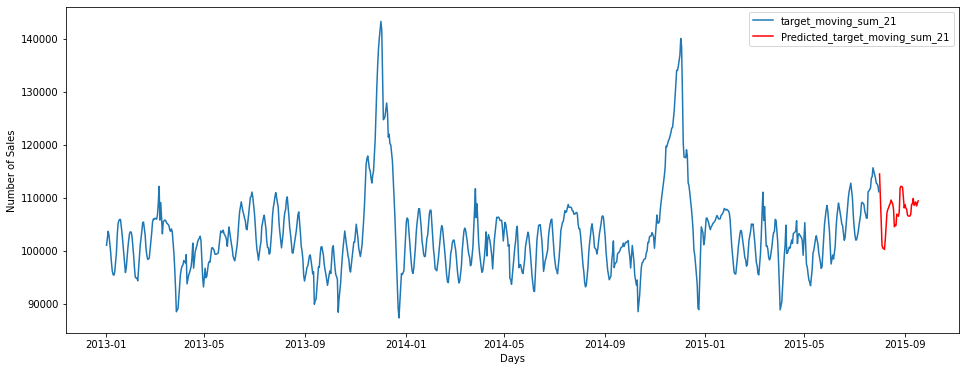

In [176]:
fig, ax = plt.subplots()

ax.plot(testing['Date'], testing['target_moving_sum_21'], label='target_moving_sum_21')
ax.plot(testing2['Date'], testing2['Pred'], label='Predicted_target_moving_sum_21',color='red')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Number of Sales')
plt.gcf().set_size_inches(16, 6)
plt.show()

### You can see that our model reproduces very well the target_moving_sum_21, let's see about the Sales themselves.

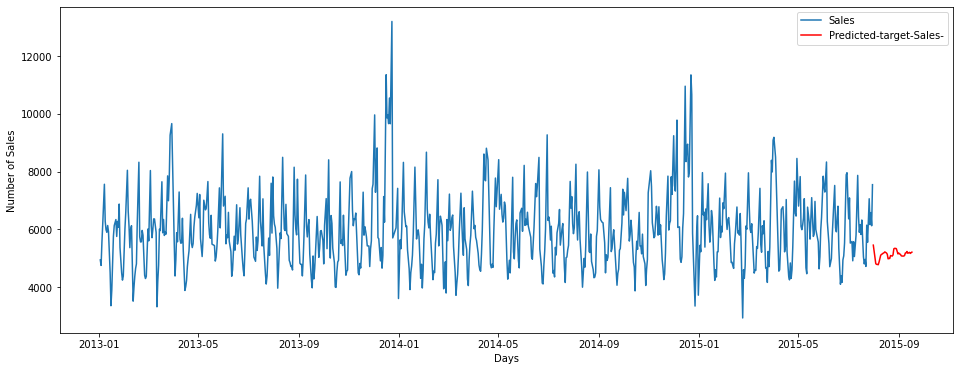

In [177]:
# create two sample dataframes
# create a figure and axis object
fig, ax = plt.subplots()

ax.plot(testing['Date'], testing['Sales'], label='Sales')
ax.plot(testing2['Date'], testing2['Sales'], label='Predicted-target-Sales-',color='red')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Number of Sales')
plt.gcf().set_size_inches(16, 6)
plt.show()

### As can be seen, it is not as good as the previous one but still does the job (Predict the Sales) reasonably well. This difference looks related to the fact of how I computed the Sales from the target_moving_sum_7. If I had to improve this, I would certainly think on another way to compute it.

In [178]:
df_final = df_andre[['Store','Date','Sales']]
df_final['Sales'] = df_final['Sales'].round(2)
df_final = df_final[df_final['Date']>'2015-07-31']
df_final

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Store,Date,Sales
1050620,1,2015-08-01,5294.08
1051474,1,2015-08-02,4936.01
1052330,1,2015-08-03,4869.52
1053187,1,2015-08-04,4813.32
1054042,1,2015-08-05,4794.37
...,...,...,...
1087780,1115,2015-09-13,5458.30
1088421,1115,2015-09-14,5449.44
1089412,1115,2015-09-15,5439.55
1090269,1115,2015-09-16,5342.81


In [179]:
def features_diff_mov(df, janelas):
    for window in janelas:
        df['Sales_moving_diff_' + str(window)] = df.groupby(["Store"])['Pred']\
                                                 .transform(lambda x: x.shift(1)\
                                                 #.rolling(window=window, min_periods=window)\
                                                 .diff(periods=21))
    return df

# Final notes here: 
### There are several other things that could be done in this data analysis/modelling, I will list some here:
### 1. Outliers analysis: I could have taken a better look at the outliers here, I mentioned the fact that only few stores on few days <50 have shown no Sales while opened. This could have been a thing to investigate further. 
### 2. Moving_averages: You may have noticed that in the initial part of the analysis, I was using the moving_average and then I suddenly stop using it. My explaination is simple on this matter, I believe the model worked without them and did not have time to check whether it would improve or not the results, but this is certainly something to check on.
### 3. Model XGRB parameters: I think we can improve a bit more the parameters by playing a bit more with them.
### 4. Other models: I could have tried other ML models, it's true that if the results are satisfatory, we are happy, but we can always try to improve them and I think selecting the most efficient and accurate model is a way to do it. Therefore, yes, another possibility is to try different models rather than XGRB, for instance.

In [ ]:
## I hope you have enjoyed my approach and that most of my steps were reasonably explained. 
## Do no hesitate to reach me out otherwise.

In [187]:
testa = conca_df.copy()

In [191]:
testa = testa[(testa['Store']==670)&(testa['Date']>'2014-06-29')]

Text(0, 0.5, 'Sales')

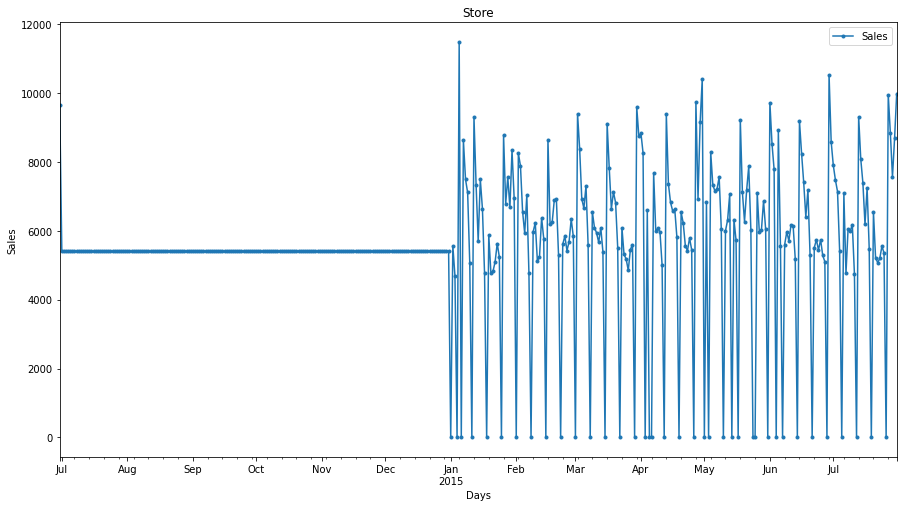

In [194]:
testa_1 = testa[testa['Store']==670]
testa_1.plot(x='Date',y='Sales',style='.-', 
                figsize=(15, 8), label="Sales",title='Store')
plt.xlabel('Days')
plt.ylabel('Sales')